In [1]:
import polars as pl
import numpy as np
import os
import json
os.chdir(os.path.expanduser('~/vivarium-ecoli'))
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix

## Load in data from literature sources

In [2]:
#TODO: MIA USE THIS PLOT STYLE: https://seaborn.pydata.org/generated/seaborn.stripplot.html

In [3]:
# load in the "ground truth" data that cyrus collected from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/): 
GT_data = pd.read_csv("notebooks/mia notebooks/cofactor_ground_truth_data_from_cyrus_for_mia.csv")
GT_data
# TODO: if some of these are below the LOD, should I not include them?
# TODO: does "cell" here just mean its the number for one cell? 
# TODO: why is the log_concentration negative here?


,Condition,Below_LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log_concentration,Concentration_(M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1000.000000,-5.485784,3.267501e-06,3983.324414
1,Minimal,0,1,ZN,205.106947,354.00,9.08603,55212.922173,-3.785417,1.639017e-04,199808.236064
2,Minimal,0,1,CU,149.815832,354.00,9.08603,1000.000000,-5.191123,6.439870e-06,7850.676467
3,Minimal,1,1,NI,137.331179,354.00,9.08603,1000.000000,-5.508529,3.100778e-06,3780.077086
4,Minimal,1,1,CO,103.448109,354.00,9.08603,1000.000000,-6.369963,4.266155e-07,520.075813
5,Minimal,0,1,FE,203.321486,354.00,9.08603,24669.603524,-3.830810,1.476353e-04,179978.374255
6,Minimal,0,1,MN,135.088853,354.00,9.08603,1000.000000,-5.565538,2.719333e-06,3315.067378
7,Minimal,0,1,CR,122.171244,354.00,9.08603,1000.000000,-5.893951,1.276582e-06,1556.247155
8,Minimal,0,1,V,113.253635,354.00,9.08603,1000.000000,-6.120670,7.574077e-07,923.335846
9,Rich,0,1,MO,146.248788,353.14,9.30606,1000.000000,-5.272756,5.336351e-06,10797.032626


In [4]:
# load in LB media data from Huynh et al., 2022 fig 1c (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
LBM_1C = pd.read_excel("notebooks/mia notebooks/Huynh_2022_F1C_LB_media_data.xlsx")
LBM_1C

,metal,atoms/CFU (on log scale),10^ column B,atoms/CFU (non-log scale option),10^ col D
0,Mn,1.924024,83.950673,3.557895,3613.222757
1,Fe,3.409036,2564.696228,5.793684,621847.955106
2,Cu,2.499739,316.038075,4.581053,38111.200706
3,Zn,2.475621,298.965655,4.543158,34926.727413


In [5]:
# load in LB media from Huynh et al., 2022 fig 1d LB (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
LBM_1D = pd.read_excel("notebooks/mia notebooks/Huynh_2022_F1D_LB_media_data.xlsx")
LBM_1D

,metal,atoms/CFU (on log scale),10^ column B,atoms/CFU (non-log scale option),10^ col D
0,V,NAN,NAN,2.708245,510.793360
1,Cr,NAN,NAN,4.232558,17082.763938
2,Co,NAN,NAN,1.983087,96.180423
3,Ni,NAN,NAN,3.389006,2449.099009


In [6]:
# data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data): 
LBM_F1_2019 = pd.read_excel("notebooks/mia notebooks/Budhraja_2019_F1_data.xlsx")
LBM_F1_2019

,metal,metal ions per cell (ranging from 1000 to 1E+09),Upper error,lower error,metal ions per cell (using 3 to 9 as the axis only),Upper Error,Lower Error,10^ (col E)
0,Mo,1.455079e+04,1.497124e+04,1.414215e+04,4.166667,4.179012,4.154321,1.467799e+04
1,Ni,1.394215e+04,1.475952e+04,1.317006e+04,4.148148,4.172840,4.123457,1.406527e+04
2,Co,3.261385e+03,3.502111e+03,2.994254e+03,3.518519,3.549383,3.481481,3.300035e+03
3,Fe,2.038348e+06,2.157847e+06,1.953087e+06,6.308642,6.333333,6.290123,2.035363e+06


In [7]:
# data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T112_2017 = pd.read_excel("notebooks/mia notebooks/Umemura_2017_T112_data.xlsx")
LBM_T112_2017

,Atomic number,Symbol,E. coli MG1655 in LB,E. coli MG1655 in M9,Synechocystis sp. PCC6803 in BG-11,Chlorella kessleri NIES-2160 in Gamborg’s B5,Chloroplast from spinach,Mitochondria from potato tuber,Mitochondria from bovine liver
0,12,Mg,7.500000e+07,110000000.0,120000000.0,1.500000e+09,320000000.0,310000.0,130000.0
1,15,P,4.200000e+08,560000000.0,470000000.0,2.300000e+10,990000000.0,37000000.0,16000000.0
2,16,S,1.700000e+08,150000000.0,400000000.0,1.100000e+10,430000000.0,4400000.0,11000000.0
3,19,K,2.600000e+08,420000000.0,410000000.0,1.800000e+10,760000000.0,15000000.0,9300000.0
4,20,Ca,6.200000e+06,3800000.0,33000000.0,3.600000e+09,14000000.0,80000.0,42000.0
5,21,Sc,4.200000e+02,260.0,NaN,NaN,NaN,NaN,NaN
6,22,Ti,3.900000e+03,NaN,83000.0,9.700000e+06,470000.0,7400.0,1400.0
7,23,V,3.200000e+03,NaN,NaN,NaN,7000.0,220.0,NaN
8,24,Cr,6.000000e+03,4600.0,9700.0,1.500000e+06,15000.0,260.0,58.0
9,25,Mn,1.900000e+05,44000.0,5000000.0,1.000000e+07,3100000.0,3000.0,2500.0


In [8]:
# data from Umemura et al., 2017, table 11.3 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T113_2017 = pd.read_excel("notebooks/mia notebooks/Umemura_2017_T113_data.xlsx")
LBM_T113_2017

,Atomic number,Symbol,Concentration in LB medium (μg/L),Unnamed: 3,Unnamed: 4,Concentration in M9 medium (μg/L),Unnamed: 6,Unnamed: 7
0,12,Mg,6310.000000,±,240.000000,2.410000e+04,±,250.0000
1,15,P,150000.000000,±,4000.000000,1.730000e+06,±,20000.0000
2,16,S,103000.000000,±,4000.000000,3.010000e+04,±,200.0000
3,19,K,739000.000000,±,41000.000000,8.830000e+05,±,6100.0000
4,20,Ca,8030.000000,±,340.000000,4.050000e+03,±,80.0000
5,21,Sc,0.085000,±,0.014000,NaN,n.d. (<0.02),NaN
6,22,Ti,13.800000,±,5.300000,2.740000e+00,±,0.1700
7,23,V,79.700000,±,4.500000,NaN,n.d. (<0.04),NaN
8,24,Cr,4.580000,±,0.110000,2.110000e+00,±,0.1600
9,25,Mn,18.400000,±,1.000000,2.650000e+00,±,0.0900


Prep data to be merged: 

In [9]:
# LB media data from GT data: 
GT_lb_data = GT_data[9:]
GT_lb_df = pl.DataFrame(GT_lb_data[["Element","Atoms/cell"]])
GT_lb_df = GT_lb_df.with_columns(pl.col("Atoms/cell").log10().alias("GT_lb_log_APC"))

# replace the element names with the column names:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_lb_df = GT_lb_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_lb_df

Element,Atoms/cell,GT_lb_log_APC
str,f64,f64
"""Mo""",10797.032626,4.033304
"""Zn""",399640.415582,5.601669
"""Cu""",87576.66829,4.942388
"""Ni""",3240.269333,3.510581
"""Co""",443.558908,2.646951
"""Fe""",607143.184501,5.783291
"""Mn""",46743.626407,4.669722
"""Cr""",3414.351358,3.533308
"""V""",249.432594,2.396953


In [10]:
# minimal media from first paper: 
LBM_1C_df = pl.DataFrame(LBM_1C[["metal","atoms/CFU (non-log scale option)"]])
LBM_1C_df = LBM_1C_df.with_columns(pl.col("atoms/CFU (non-log scale option)").alias("LBM_Huynh_log_APC"))

LBM_1D_df = pl.DataFrame(LBM_1D[["metal","atoms/CFU (non-log scale option)"]])
LBM_1D_df = LBM_1D_df.with_columns(pl.col("atoms/CFU (non-log scale option)").alias("LBM_Huynh_log_APC"))

# add the rows from LBM_1D to the bottom of LBM_1C:
LBM_F1_2022_df = LBM_1C_df.vstack(LBM_1D_df)
LBM_F1_2022_df

metal,atoms/CFU (non-log scale option),LBM_Huynh_log_APC
str,f64,f64
"""Mn""",3.557895,3.557895
"""Fe""",5.793684,5.793684
"""Cu""",4.581053,4.581053
"""Zn""",4.543158,4.543158
"""V""",2.708245,2.708245
"""Cr""",4.232558,4.232558
"""Co""",1.983087,1.983087
"""Ni""",3.389006,3.389006


In [11]:
# minimal media from second paper:
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","metal ions per cell (ranging from 1000 to 1E+09)"]])
# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("metal ions per cell (ranging from 1000 to 1E+09)").log10().alias("LBM_Budhraja_log_APC"))
LBM_F1_2019_df

metal,metal ions per cell (ranging from 1000 to 1E+09),LBM_Budhraja_log_APC
str,f64,f64
"""Mo""",14550.790838,4.162887
"""Ni""",13942.154688,4.14433
"""Co""",3261.384943,3.513402
"""Fe""",2.0383e6,6.309278


In [12]:
# minimal media from third paper: LBM_T112_2017
LBM_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in LB"]])
LBM_T112_2017_df = LBM_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in LB").log10().alias("LBM_Umemura_T112_log_APC"))
LBM_T112_2017_df

Symbol,E. coli MG1655 in LB,LBM_Umemura_T112_log_APC
str,f64,f64
"""Mg""",7.5e7,7.875061
"""P""",4.2e8,8.623249
"""S""",1.7e8,8.230449
"""K""",2.6e8,8.414973
"""Ca""",6.2e6,6.792392
…,…,…
"""Au""",0.25,-0.60206
"""Tl""",45.0,1.653213
"""Pb""",60.0,1.778151


In [13]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source
H_2022 = LBM_F1_2022_df.select(["metal", "LBM_Huynh_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
B_2019 = LBM_F1_2019_df.select(["metal", "LBM_Budhraja_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
U_T112 = LBM_T112_2017_df.select(["Symbol", "LBM_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))

# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
H_2022 = H_2022.rename({"metal": "Element"})
B_2019 = B_2019.rename({"metal": "Element"})
U_T112 = U_T112.rename({"Symbol": "Element"})

# Ensure unique column names before joining
H_2022 = H_2022.rename({"LBM_Huynh_log_APC": "Huynh et al., 2022"})
B_2019 = B_2019.rename({"LBM_Budhraja_log_APC": "Budhraja et al., 2019"})
U_T112 = U_T112.rename({"LBM_Umemura_T112_log_APC": "Umamura et al., 2017"})

# Perform outer joins to combine the DataFrames
lb_exp_data = H_2022.join(B_2019, on="Element", how="left")
lb_exp_data = lb_exp_data.join(U_T112, on="Element", how="left")
lb_exp_data

Element,"Huynh et al., 2022","Budhraja et al., 2019","Umamura et al., 2017"
str,f64,f64,f64
"""Mn""",3.557895,null,5.278754
"""Fe""",5.793684,6.309278,6.518514
"""Cu""",4.581053,null,4.778151
"""Zn""",4.543158,null,5.812913
"""V""",2.708245,null,3.50515
"""Cr""",4.232558,null,3.778151
"""Co""",1.983087,3.513402,3.740363
"""Ni""",3.389006,4.14433,4.113943


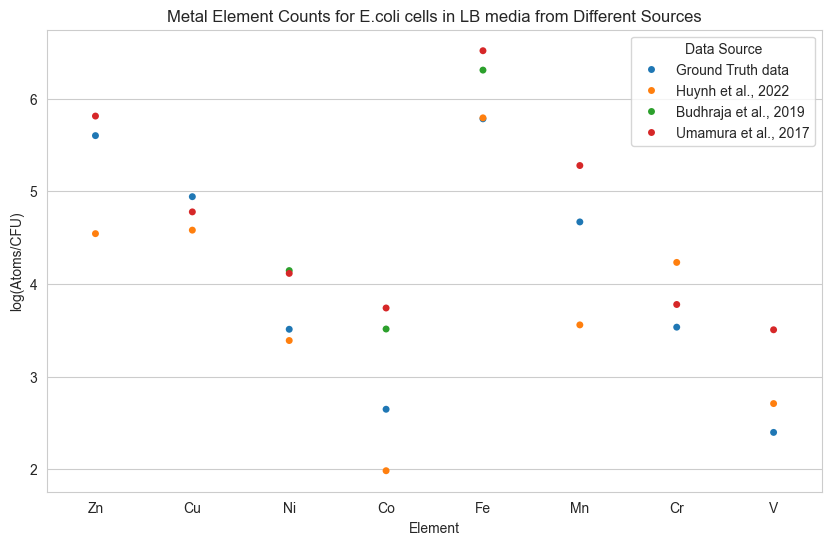

In [24]:
# Combine all data: 
# TODO: ask cyrus if i should be using the minimal media GT data or the Rich media (I read a paper that said the rich media=LB media)
GT_lb = GT_lb_df.select(["Element", "GT_lb_log_APC"])
GT_lb = GT_lb.rename({"GT_lb_log_APC": "Ground Truth data"})
lb_df = GT_lb.join(lb_exp_data, on="Element", how="inner")

# Melt the Polars DataFrame to long format
df_long = lb_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log(Atoms/CFU)")
# Convert to Pandas DataFrame
df_long_pd = df_long.to_pandas()

# Create the strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long_pd, y="log(Atoms/CFU)", x="Element", hue="Data Source", jitter=False)
plt.title("Metal Element Counts for E.coli cells in LB media from Different Sources")
plt.show()


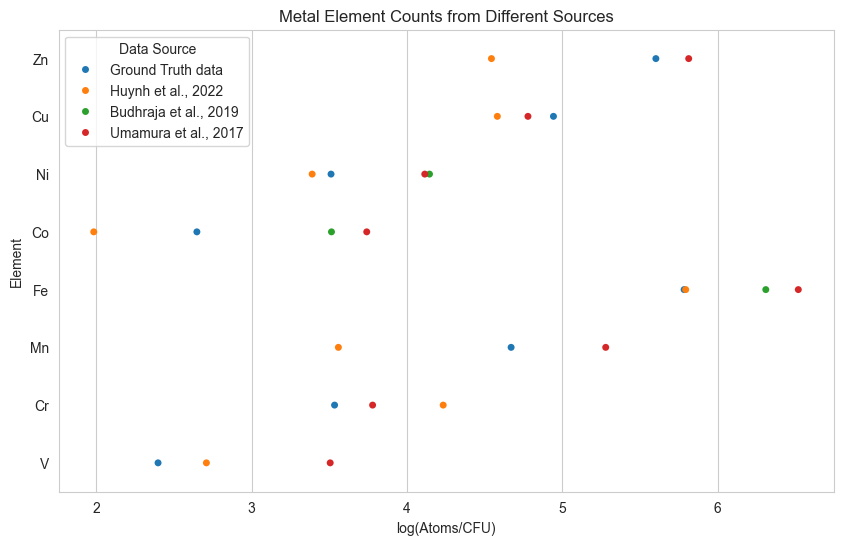

In [25]:
# other orientation: 
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long_pd, x="log(Atoms/CFU)", y="Element", hue="Data Source", jitter=False)
plt.title("Metal Element Counts from Different Sources")
plt.show()

# Minimal media plots 

In [16]:
# minimal media data from GT data: 
GT_mm_data = GT_data[:9]
GT_mm_df = pl.DataFrame(GT_mm_data[["Element","Atoms/cell"]])
GT_mm_df = GT_mm_df.with_columns(pl.col("Atoms/cell").log10().alias("GT_mm_log_APC"))

# replace the element names with the column names:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_mm_df = GT_mm_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_mm_df

Element,Atoms/cell,GT_mm_log_APC
str,f64,f64
"""Mo""",3983.324414,3.600246
"""Zn""",199808.236064,5.300613
"""Cu""",7850.676467,3.894907
"""Ni""",3780.077086,3.577501
"""Co""",520.075813,2.716067
"""Fe""",179978.374255,5.25522
"""Mn""",3315.067378,3.520492
"""Cr""",1556.247155,3.192079
"""V""",923.335846,2.96536


In [17]:
# minimal media from Umamura et al., 2017, table 11.2: 
M9_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in M9"]])
M9_T112_2017_df = M9_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in M9").log10().alias("M9_Umemura_T112_log_APC"))
M9_T112_2017_df

Symbol,E. coli MG1655 in M9,M9_Umemura_T112_log_APC
str,f64,f64
"""Mg""",1.1e8,8.041393
"""P""",5.6e8,8.748188
"""S""",1.5e8,8.176091
"""K""",4.2e8,8.623249
"""Ca""",3.8e6,6.579784
…,…,…
"""Au""",null,null
"""Tl""",null,null
"""Pb""",120.0,2.079181


In [31]:
# load in the data from Yan et al., 2019, figure 1A (https://www.sciencedirect.com/science/article/pii/S002192582030538X?via%3Dihub#sec1):
Xu_F1A_2019 = pd.read_excel("notebooks/mia notebooks/Xu_2019_F1A_data.xlsx")
# TODO confirm that this is minimal media and it is MOPS minimal media
MOPS_Xu_2019 = pl.DataFrame(Xu_F1A_2019[["Element","Intracellular metal content (per cell) in No Zn(II) supplement"]])
# TODO: ask cyrus if he knows if this is already log transformed or not?
MOPS_Xu_2019 = MOPS_Xu_2019.with_columns(pl.col("Intracellular metal content (per cell) in No Zn(II) supplement").log10().alias("MOPS_Xu_log_APC"))
MOPS_Xu_2019

Element,Intracellular metal content (per cell) in No Zn(II) supplement,MOPS_Xu_log_APC
str,f64,f64
"""Zn""",1.4,0.146128
"""Fe""",3.8,0.579784
"""Mn""",3.2,0.50515
"""Ni""",0.3,-0.522879
"""Cu""",2.0,0.30103


In [32]:
# the rich media from this paper is made rich by the fact that there is a little bit of Zn in it:
# TODO ask cyrus if this is the right data to use for rich media (or minimal instead)
Zn_Xu_2019 = pl.DataFrame(Xu_F1A_2019[["Element","Intracellular metal content (per cell) in 0.1 mM Zn(II)"]])
Zn_Xu_2019 = Zn_Xu_2019.with_columns(pl.col("Intracellular metal content (per cell) in 0.1 mM Zn(II)").log10().alias("Zn_Xu_log_APC"))
Zn_Xu_2019

Element,Intracellular metal content (per cell) in 0.1 mM Zn(II),Zn_Xu_log_APC
str,f64,f64
"""Zn""",4.9,0.690196
"""Fe""",4.8,0.681241
"""Mn""",3.5,0.544068
"""Ni""",0.3,-0.522879
"""Cu""",1.4,0.146128


In [33]:
# load in the Osman data from: https://www.nature.com/articles/s41589-018-0211-4#Sec24
Osman_ST3_2019 = pd.read_excel("notebooks/mia notebooks/Osman_2019_ST3_data.xlsx")
Osman_ST3_2019
#TODO: ask cyrus if the "metals exposed" data is something we also want to plot?


,Element,"Total Metal (atoms/cell), Control","Total Metal (atoms/cell), Metal Exposed"
0,Mg,26000000,0.0
1,Mn,160000,180000.0
2,Fe,200000,970000.0
3,Co,900,35600.0
4,Zn,190000,230000.0
5,Ni,4600,27400.0
6,Cu,5100,242600.0


In [34]:
# Osman minimal media data: 
M9_Osman_2019 = pl.DataFrame(Osman_ST3_2019[["Element","Total Metal (atoms/cell), Control"]])
M9_Osman_2019 = M9_Osman_2019.with_columns(pl.col("Total Metal (atoms/cell), Control").log10().alias("M9_Osman_log_APC"))
M9_Osman_2019

Element,"Total Metal (atoms/cell), Control",M9_Osman_log_APC
str,i64,f64
"""Mg""",26000000,7.414973
"""Mn""",160000,5.20412
"""Fe""",200000,5.30103
"""Co""",900,2.954243
"""Zn""",190000,5.278754
"""Ni""",4600,3.662758
"""Cu""",5100,3.70757


In [35]:
# load in LaVoie Data from: https://link.springer.com/article/10.1007/s00775-015-1303-1
LaVoie_F4_2015 = pd.read_excel("notebooks/mia notebooks/LaVoie_2015_F4_data.xlsx")
LaVoie_F4_2015

,Element,unexposed,40 µM PMA,160 µM MT,16 µM HgCl2,80 µM HgCl2
0,Mg,7.339623,7.382749,7.469003,7.506739,7.339623
1,Mn,4.450135,4.234501,4.730458,3.932615,4.423181
2,Fe,5.894879,5.700809,5.808625,5.851752,5.700809
3,Co,3.975741,3.927224,3.932615,3.867925,3.932615
4,Ni,3.609164,4.148248,3.846361,3.711590,3.544474
5,Cu,4.277628,4.471698,4.514825,4.563342,4.277628
6,Zn,4.838275,4.795148,5.204852,4.843666,4.730458


In [39]:
# minimal media data from LaVoie:
MOPS_LaVoie_2015 = pl.DataFrame(LaVoie_F4_2015[["Element","unexposed"]])
MOPS_LaVoie_2015 = MOPS_LaVoie_2015.rename({"unexposed": "MOPS_LaVoie_log_APC"})
# TODO: figure out if this is already in the correct log transformed format
MOPS_LaVoie_2015

Element,MOPS_LaVoie_log_APC
str,f64
"""Mg""",7.339623
"""Mn""",4.450135
"""Fe""",5.894879
"""Co""",3.975741
"""Ni""",3.609164
"""Cu""",4.277628
"""Zn""",4.838275


In [40]:
# load in data from Beauchene 2014: https://asset.library.wisc.edu/1711.dl/LE7AB2DFQKDIP8O/R/file-1aa76.pdf
Beauchene_T2_2014 = pd.read_excel("notebooks/mia notebooks/Beauchene_2014_T2_2_data.xlsx")
Beauchene_T2_2014

,Element,Aerobic\nGrowth (µg/mL cell lysate),Standard Error,Anaerobic\nGrowth (µg/mL cell lysate),Standard Error.1,Aerobic/Anaerobic\nFold-Change
0,Mn,1.066,0.084,0.029,0.001,36.6
1,Co,0.070,0.008,0.013,0.000,5.5
2,Ni,0.012,0.001,0.007,0.002,1.7
3,Zn,2.143,0.050,1.341,0.024,1.6
4,Mg,139.169,1.723,105.962,1.016,1.3
5,P,1052.066,10.473,880.023,3.144,1.2
6,S,556.084,9.182,512.049,5.556,1.1
7,Fe,6.306,0.371,7.508,0.087,0.8
8,K,332.128,12.840,516.316,3.029,0.6
9,Cu,0.163,0.010,0.270,0.046,0.6


In [ ]:
# minimal media data from Beauchene (aerobic conditions)
MOPS_aerobic_Beauchene_2014 = pl.DataFrame(Beauchene_T2_2014[["Element","Aerobic\\nGrowth (µg/mL cell lysate)"]])
# todo: I know i have to use each elements molecular mass here, but I also need to know the total mass of cells or the volume of the cell lysate to convert this to atoms/cell.. ask cyrus if he has any ideas on how to estimate these properly 13,140 or 13,190 